In [5]:
import numpy as np
import pandas as pd


In [6]:
df1=pd.read_csv('synthetic_behavior_dataset.csv')
df1.head()
df1.head()

,user_id,session_id,device_type,click_events,scroll_events,touch_events,keyboard_events,device_motion,time_on_page,screen_size,browser_info,language,timezone_offset,device_orientation,geolocation_city,transaction_amount,transaction_date,mouse_movement,label
0,user_102,session_0,Mobile,4,3,9,7,2.07,154,1920x1080,Edge,english,480,portrait,Unknown,121.06,2024-05-09,0,0
1,user_435,session_1,Mobile,6,6,5,6,0.17,10,1920x1080,Safari,english,0,portrait,Mumbai,508.39,2024-12-02,0,0
2,user_348,session_2,PC,6,12,0,11,0.00,41,1440x900,Firefox,foreign,60,portrait,Indore,8.70,2024-11-11,111,0
3,user_270,session_3,Mobile,9,6,4,8,0.86,70,1366x768,Edge,english,60,portrait,Unknown,294.68,2024-09-23,0,0
4,user_106,session_4,PC,3,10,0,12,0.00,14,1366x768,Chrome,foreign,480,none,Delhi,1649.47,2024-09-17,31,0


In [20]:
df2=pd.read_csv('balanced_dataset_30%_anomalies.csv')
df2.head()
df3=pd.read_csv('balanced_dataset_40%_anomalies.csv')
df3.head()
print(df3.info())
df3.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             5000 non-null   object 
 1   session_id          5000 non-null   object 
 2   device_type         5000 non-null   object 
 3   click_events        5000 non-null   int64  
 4   scroll_events       5000 non-null   int64  
 5   touch_events        5000 non-null   int64  
 6   keyboard_events     5000 non-null   int64  
 7   device_motion       5000 non-null   float64
 8   time_on_page        5000 non-null   int64  
 9   screen_size         5000 non-null   object 
 10  browser_info        5000 non-null   object 
 11  language            5000 non-null   object 
 12  timezone_offset     5000 non-null   int64  
 13  device_orientation  5000 non-null   object 
 14  geolocation_city    5000 non-null   object 
 15  transaction_amount  5000 non-null   float64
 16  transa

,click_events,scroll_events,touch_events,keyboard_events,device_motion,time_on_page,timezone_offset,transaction_amount,mouse_movement,label
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,6.506000,9.063800,3.916800,10.116800,0.597396,88.704200,111.438000,1470.876924,114.583600,0.400000
std,2.960695,4.274972,4.440926,5.933346,0.699261,87.377991,281.005525,1469.787205,195.334866,0.489947
min,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,-330.000000,0.190000,0.000000,0.000000
25%,4.000000,6.000000,0.000000,5.000000,0.000000,26.000000,0.000000,426.307500,0.000000,0.000000
50%,6.000000,8.500000,0.000000,9.000000,0.000000,61.000000,60.000000,1020.515000,20.000000,0.000000
75%,8.000000,12.000000,8.000000,15.000000,1.192500,123.000000,330.000000,2034.412500,153.000000,1.000000
max,20.000000,30.000000,19.000000,29.000000,3.050000,600.000000,480.000000,13614.530000,1545.000000,1.000000


In [8]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# -------------------------------
# Step 1: Custom Feature Generator
# -------------------------------
class SmartFeatureGenerator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = X.copy()
        df['transaction_date'] = pd.to_datetime(df['transaction_date'])
        # Datetime decomposition
        df['transaction_hour'] = df['transaction_date'].dt.hour
        df['transaction_day'] = df['transaction_date'].dt.dayofweek
        df['month'] = df['transaction_date'].dt.month
        df['hour'] = df['transaction_date'].dt.hour
        df['is_weekend'] = df['transaction_day'].isin([5, 6]).astype(int)
        

        # Avoid divide-by-zero
        df['time_on_page'] = df['time_on_page'].replace(0, 1)

        # Smart features (rates)
        df['clicks_per_sec'] = df['click_events'] / df['time_on_page']
        df['scrolls_per_sec'] = df['scroll_events'] / df['time_on_page']
        df['touches_per_sec'] = df['touch_events'] / df['time_on_page']
        df['keyboard_per_sec'] = df['keyboard_events'] / df['time_on_page']
        df['mouse_per_sec'] = df['mouse_movement'] / df['time_on_page']

        # Interaction and ratios
        df['interaction_score'] = (
            df['click_events'] +
            df['scroll_events'] +
            df['touch_events'] +
            df['keyboard_events']
        ) / df['time_on_page']
        df['click_to_scroll_ratio'] = df['click_events'] / (df['scroll_events'] + 1)
        df['touch_to_click_ratio'] = df['touch_events'] / (df['click_events'] + 1)
        #keyboard_to_click_ratio
        df['keyboard_to_click_ratio'] = df['keyboard_events'] / (df['click_events'] + 1)
        
        # total events feature
        df['total_events'] = df['click_events'] + df['scroll_events'] + df['touch_events'] + df['keyboard_events']
        df['events_per_second']=df['total_events']/df['time_on_page']
        #screen faetures
        # 8. Screen Size Features
        df[['screen_width', 'screen_height']] = df['screen_size'].str.split('x', expand=True).astype(int)
        df['screen_area'] = df['screen_width'] * df['screen_height']
        df['screen_ratio'] = df['screen_width'] / (df['screen_height'] + 1)
        
        df['mouse_per_click'] = df['mouse_movement'] / (df['click_events'] + 1)
        df['motion_per_event'] = df['device_motion'] / (df['total_events'] + 1)
        df['motion_per_second'] = df['device_motion'] / (df['time_on_page'] + 1)
        
        # 13. Transaction Features
        df['transaction_per_event'] = df['transaction_amount'] / (df['total_events'] + 1)
        df['transaction_per_second'] = df['transaction_amount'] / (df['time_on_page'] + 1)
        
         # 14. Interaction Diversity (must be created before other features that use it)
        df['interaction_diversity'] = df[['click_events', 'scroll_events', 'touch_events', 'keyboard_events']].std(axis=1)
        
        # 15. Behavioral Consistency
        df['behavioral_consistency'] = 1 / (df['interaction_diversity'] + 1)
        
        # 16. Session Efficiency
        df['session_efficiency'] = df['total_events'] / (df['time_on_page'] + 1)
        df['click_efficiency'] = df['click_events'] / (df['time_on_page'] + 1)
        
        # 17. Advanced Ratios
        df['input_to_navigation_ratio'] = (df['keyboard_events'] + df['touch_events']) / (df['click_events'] + df['scroll_events'] + 1)
        df['active_to_passive_ratio'] = (df['click_events'] + df['touch_events']) / (df['scroll_events'] + 1)
        
        # 18. Additional Production Features
        df['session_complexity'] = df['total_events'] * df['interaction_diversity']
        #df['device_behavior_score'] = df['is_mobile'] * df['touch_rate'] + df['is_pc'] * df['mouse_per_second']
        df['time_behavior_score'] = df['hour'] * df['events_per_second']
        



        # Deviation score per user
        user_avg = df.groupby('user_id')['interaction_score'].transform('mean')
        df['deviation_score'] = np.abs(df['interaction_score'] - user_avg)

        return df

# -------------------------------
# Step 2: Define Columns
# -------------------------------
categorical = [
    'device_type',
    'browser_info',
    'language',
    'screen_size',
    'device_orientation',
    'geolocation_city',
    'is_weekend',
    #'user_id',  # Optional: If you're one-hot encoding users (for small user bases)
]

numerical = [
    # Raw features or rates
    'clicks_per_sec', 'scrolls_per_sec', 'touches_per_sec',
    'keyboard_per_sec', 'mouse_per_sec',
    # Interaction and ratios
    'interaction_score', 'click_to_scroll_ratio', 'touch_to_click_ratio',
    'keyboard_to_click_ratio',
    # Totals
    'total_events',
    # Screen features
    'screen_width', 'screen_height', 'screen_area', 'screen_ratio',
    'mouse_per_click',
    # Device motion
    'motion_per_event', 'motion_per_second',
    # Transaction-related
    'transaction_amount',  # Only if present in raw data
    'transaction_per_event', 'transaction_per_second',
    # Time features
    'transaction_hour', 'transaction_day', 'hour', 'month',
    # Behavioral metrics
    'interaction_diversity', 'behavioral_consistency',
    'session_efficiency', 'click_efficiency',
    'input_to_navigation_ratio', 'active_to_passive_ratio',
    # Composite metrics
    'session_complexity', 'time_behavior_score',
    # Deviation
    'deviation_score',
]


# -------------------------------
# Step 3: Define ColumnTransformer
# -------------------------------

preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), numerical),
    
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical)
])

# -------------------------------
# Step 4: Full Pipeline
# -------------------------------
full_pipeline = Pipeline(steps=[
    ('feature_gen', SmartFeatureGenerator()),
    ('preprocessing', preprocessor)
])


In [9]:
X_ready = full_pipeline.fit_transform(df3)
pd.DataFrame(X_ready)



,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,-0.723649,-0.752375,-0.262345,-0.640413,-1.006267,-0.760552,0.542120,0.899181,-0.052167,-0.847500,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,1.713425,0.968582,1.636085,0.722216,-1.006267,1.432379,0.239988,-0.064463,-0.616541,-0.847500,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,-0.212619,0.057537,-0.513608,-0.092856,1.127942,-0.191616,-0.596685,-0.698439,0.126057,-0.077442,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,-0.288063,-0.556024,-0.267929,-0.471281,-1.006267,-0.519542,1.146384,-0.343412,-0.675948,-0.334128,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.075844,1.307383,-0.513608,1.354067,0.739280,0.907982,-0.996006,-0.698439,1.611251,-0.590814,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-0.772982,-0.753388,-0.307896,-0.705077,-1.006267,-0.810385,-0.303849,1.520478,-0.468021,-1.104187,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4996,-0.438986,-0.396472,-0.013679,-0.409239,-1.006267,-0.414865,-0.364276,0.189128,-0.260094,-1.104187,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4997,-0.676680,-0.634450,-0.195135,-0.624694,-1.006267,-0.686248,-0.397846,0.780839,-0.294748,0.050901,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4998,-0.724124,-0.733457,-0.328289,-0.667373,-1.006267,-0.780986,0.013389,0.411020,-0.468021,-1.874245,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

def build_autoencoder(input_dim: int, encoding_dim: int = 16) -> Model:
    """
    Builds and returns a compiled Autoencoder model.

    Parameters:
    - input_dim (int): Number of input features
    - encoding_dim (int): Size of the bottleneck layer

    Returns:
    - autoencoder (Model): Compiled Keras Autoencoder model
    """

    # Input layer
    input_layer = Input(shape=(input_dim,))

    # Encoder
    encoded = Dense(64, activation='relu')(input_layer)
    encoded = Dense(32, activation='relu')(encoded)
    bottleneck = Dense(encoding_dim, activation='relu')(encoded)

    # Decoder
    decoded = Dense(32, activation='relu')(bottleneck)
    decoded = Dense(64, activation='relu')(decoded)
    output_layer = Dense(input_dim, activation='linear')(decoded)

    # Define and compile model
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    return autoencoder


In [11]:
from sklearn.model_selection import train_test_split
y=df1['label']
X_ready = full_pipeline.fit_transform(df3)
X_train, X_test, y_train, y_test = train_test_split(
    X_ready, y,
    test_size=0.2,
    stratify=y,  
    random_state=42
)
X_train_normal = X_train[y_train == 0]


# Hybrid Model


In [12]:
'''X_processed = full_pipeline.fit_transform(df1)
y_0 = df1['label']
X=X_processed[y_0==0]
autoencoder = build_autoencoder(input_dim=X_processed.shape[1], encoding_dim=8)
from tensorflow.keras.callbacks import EarlyStopping
autoencoder.fit(
    X,X,
    epochs=50,
    batch_size=32,validation_split=0.1,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)'''


"X_processed = full_pipeline.fit_transform(df1)\ny_0 = df1['label']\nX=X_processed[y_0==0]\nautoencoder = build_autoencoder(input_dim=X_processed.shape[1], encoding_dim=8)\nfrom tensorflow.keras.callbacks import EarlyStopping\nautoencoder.fit(\n    X,X,\n    epochs=50,\n    batch_size=32,validation_split=0.1,\n    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],\n    verbose=1\n)"

In [13]:
'''reconstructed = autoencoder.predict(X_processed)
reconstruction_error = np.mean(np.square(X_processed - reconstructed), axis=1)



from tensorflow.keras.models import Model

# Replace 'dense_1' with your bottleneck layer's name or index
bottleneck_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(index=-4).output)
bottleneck_features = bottleneck_model.predict(X_processed)

X_H=full_pipeline.fit_transform(df1)

# If you already have smart features in df, concatenate:
X_hybrid = np.concatenate([
    bottleneck_features,
    reconstruction_error.reshape(-1, 1),
    X_H  # replace with your actual feature column names
], axis=1)

y_hybrid=df1['label'].values
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split


iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.04,       # since you expect 4% anomalies
    random_state=42
)
iso_forest.fit(X_hybrid)

# Predict: -1 = anomaly, 1 = normal
y_pred_iforest = iso_forest.predict(X_hybrid)

# Convert to 0 (normal), 1 (anomaly) like before
y_pred_iforest = np.where(y_pred_iforest == -1, 1, 0)

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y, y_pred_iforest))
print(confusion_matrix(y, y_pred_iforest))
'''





"reconstructed = autoencoder.predict(X_processed)\nreconstruction_error = np.mean(np.square(X_processed - reconstructed), axis=1)\n\n\n\nfrom tensorflow.keras.models import Model\n\n# Replace 'dense_1' with your bottleneck layer's name or index\nbottleneck_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(index=-4).output)\nbottleneck_features = bottleneck_model.predict(X_processed)\n\nX_H=full_pipeline.fit_transform(df1)\n\n# If you already have smart features in df, concatenate:\nX_hybrid = np.concatenate([\n    bottleneck_features,\n    reconstruction_error.reshape(-1, 1),\n    X_H  # replace with your actual feature column names\n], axis=1)\n\ny_hybrid=df1['label'].values\nfrom sklearn.ensemble import IsolationForest\nfrom sklearn.model_selection import train_test_split\n\n\niso_forest = IsolationForest(\n    n_estimators=100,\n    contamination=0.04,       # since you expect 4% anomalies\n    random_state=42\n)\niso_forest.fit(X_hybrid)\n\n# Predict: -1 = anoma

In [14]:
X_train_normal = X_train[y_train == 0]

input_dim = X_train.shape[1]
autoencoder = build_autoencoder(input_dim=input_dim, encoding_dim=16)

from tensorflow.keras.callbacks import EarlyStopping

history = autoencoder.fit(
    X_train_normal, X_train_normal,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_split=0.1,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)


Epoch 1/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5551 - val_loss: 0.2748
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2641 - val_loss: 0.1921
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1794 - val_loss: 0.1486
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1445 - val_loss: 0.1316
Epoch 5/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1295 - val_loss: 0.1194
Epoch 6/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1172 - val_loss: 0.1114
Epoch 7/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1088 - val_loss: 0.1025
Epoch 8/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1000 - val_loss: 0.0943
Epoch 9/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0924 - val_loss: 0.0872
Epoch 10/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0859 - val_loss: 0.0824
Epoch 11/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0823 - val_loss: 0.0789
Epoch 12/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

In [15]:

# Step 1: Get reconstructed output from the autoencoder
reconstructed = autoencoder.predict(X_test)

# Step 2: Calculate mean squared error per session (row-wise)
reconstruction_error = np.mean(np.square(X_test - reconstructed), axis=1)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [16]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

# Range of thresholds to try
thresholds = np.linspace(min(reconstruction_error), max(reconstruction_error), 200)

# Store results
results = []

for t in thresholds:
    y_pred = (reconstruction_error > t).astype(int)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    results.append((t, f1, precision, recall))

# Convert to DataFrame
import pandas as pd
results_df = pd.DataFrame(results, columns=["threshold", "f1", "precision", "recall"])

# Find the threshold with best F1
best = results_df.loc[results_df['f1'].idxmax()]
best_threshold = best['threshold']

print(f"✅ Best Threshold (Max F1): {best_threshold:.4f}")
print(f"F1: {best['f1']:.4f}, Precision: {best['precision']:.4f}, Recall: {best['recall']:.4f}")


✅ Best Threshold (Max F1): 0.0592
F1: 0.0893, Precision: 0.0543, Recall: 0.2500


In [17]:
# Predict using best threshold
y_pred = (reconstruction_error > best_threshold).astype(int)


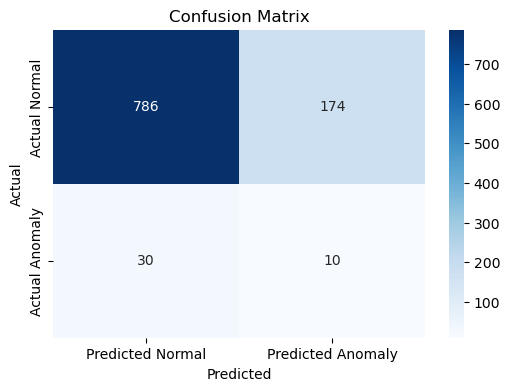

📊 Classification Report:

              precision    recall  f1-score   support

           0     0.9632    0.8187    0.8851       960
           1     0.0543    0.2500    0.0893        40

    accuracy                         0.7960      1000
   macro avg     0.5088    0.5344    0.4872      1000
weighted avg     0.9269    0.7960    0.8533      1000

🔁 F1 Score: 0.0893


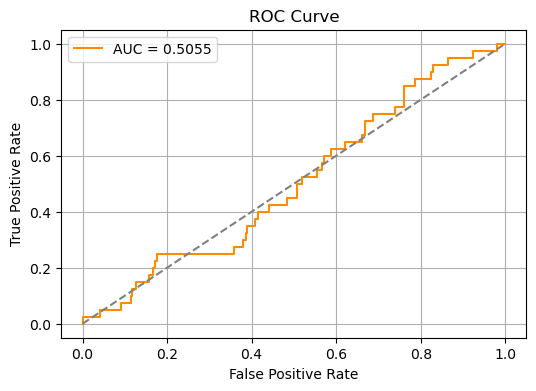

📈 ROC AUC Score: 0.5055


In [18]:
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score,
    roc_curve, roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Normal', 'Predicted Anomaly'],
            yticklabels=['Actual Normal', 'Actual Anomaly'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- 2. Classification Report ---
print("📊 Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

# --- 3. F1 Score ---
f1 = f1_score(y_test, y_pred)
print(f"🔁 F1 Score: {f1:.4f}")

# --- 4. ROC Curve & AUC ---
fpr, tpr, thresholds = roc_curve(y_test, reconstruction_error)
auc_score = roc_auc_score(y_test, reconstruction_error)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

print(f"📈 ROC AUC Score: {auc_score:.4f}")